# Import thư viện

In [1]:
import gc
import os
import sys
import cv2
import time
import torch
import importlib
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import OrderedDict

prj_path = os.path.join(os.path.abspath(''))
if prj_path not in sys.path:
    sys.path.append(prj_path)

# ProContEXT
from lib.test.evaluation.environment import env_settings
from lib.test.evaluation.running_2023 import run_dataset
from lib.test.evaluation import Sequence, Tracker, get_dataset

# SAM
from sam.segment_anything import SamPredictor, sam_model_registry
# from segment_anything import SamPredictor, sam_model_registry

# SAM + DeAOT
from SegTracker import SegTracker
from model_args import aot_args, sam_args, segtracker_args
from aot_tracker import _palette
from scipy.ndimage import binary_dilation

In [2]:
dataset_name = 'vot23'
tracker_name = 'procontext'
tracker_param = 'procontext'

# Chỉ xét bus

In [3]:
dataset = get_dataset(dataset_name)

for x in dataset:
    if x.name == 'bus':
        dataset = [x]

dataset

23 <class 'lib.test.evaluation.data.SequenceList'>


[Sequence bus, length=8087 frames]

In [4]:
len(dataset[0].init_bbox())

2

# Tạo 1 wapper mới cho tracker

In [5]:
class Tracker:
    """Wraps the tracker for evaluation and running purposes.
    
    args:
        name: Name of tracking method.
        parameter_name: Name of parameter file.
        run_id: The run id.
        display_name: Name to be displayed in the result plots.
    """
    def __init__(self, name: str, parameter_name: str, dataset_name: str, seq: Sequence, run_id: int = None, display_name: str = None,
                 result_only=False, debug=None):
        assert run_id is None or isinstance(run_id, int)

        self.name = name
        self.seq = seq
        self.seq_name = seq.name
        self.parameter_name = parameter_name
        self.dataset_name = dataset_name
        self.run_id = run_id    # Đây chính là seq_obj_id, id của từng đối tượng riêng biệt
        self.display_name = display_name
        self.output_boxes = []

        env = env_settings()
        if self.run_id is None:
            self.results_dir = '{}/{}/{}'.format(env.results_path, self.name, self.parameter_name)
        else:   # <--- từng tracker cho từng object chạy vào đây
            self.results_dir = '{}/{}/{}/{:03d}'.format(env.results_path, self.name, self.seq_name, self.run_id)
        if result_only:
            self.results_dir = '{}/{}'.format(env.results_path, self.name)
        
        tracker_module_abspath = os.path.abspath(os.path.join(os.path.abspath(''),
                                                              'lib', 'test', 'tracker', '%s.py' % self.name))
        if os.path.isfile(tracker_module_abspath):
            tracker_module = importlib.import_module('lib.test.tracker.{}'.format(self.name))
            self.tracker_class = tracker_module.get_tracker_class()
        else:
            self.tracker_class = None

        # initialize
        params = self.get_parameters()
        
        debug_ = debug
        if debug is None:
            debug_ = getattr(params, 'debug', 0)
        
        params.debug = debug_
        
        # Get init info
        temp_info = self.seq.init_info()
        temp_info['init_bbox'] = temp_info['init_bbox'][self.run_id]
        self.init_info = temp_info
        self.output_boxes.append([int(i) for i in self.init_info['init_bbox']])
        print("Init info: ", self.init_info)
        
        self.tracker = self.create_tracker(params)
        
        # Initialize tracker
        image = self._read_image(self.seq.frames[0])
        out = self.tracker.initialize(image, self.init_info)
        if out is None:
            out = {}
        
        self.prev_output = OrderedDict(out)
            
    def track(self, frame_num: int, image):
        """ Tracking every frame pass in.
        """
        # image = self._read_image(frame_path)       
        info = self.seq.frame_info(frame_num)
        info['previous_output'] = self.prev_output
        out = self.tracker.track(image, info)
        self.prev_output = OrderedDict(out)
        
        state = [int(s) for s in out['target_bbox']]
        self.output_boxes.append(state)
        return state
    
    def create_tracker(self, params):
        tracker = self.tracker_class(params, self.dataset_name)
        return tracker
    
    def get_parameters(self):
        param_module = importlib.import_module('lib.test.parameter.{}'.format(self.name))
        params = param_module.parameters(self.parameter_name)
        return params
    
    def _read_image(self, image_file: str):
        if isinstance(image_file, str):
            im = cv2.imread(image_file)
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        elif isinstance(image_file, list) and len(image_file) == 2:
            return decode_img(image_file[0], image_file[1])
        else:
            raise ValueError("type of image_file should be str or list")

# ProContEXT + SAM

### Helper function

In [6]:
np.random.seed(200)
_palette = ((np.random.random((3*255))*0.7+0.3)*255).astype(np.uint8).tolist()
_palette = [0,0,0]+_palette

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))

### Runnnn

In [7]:
sam_checkpoint = "sam/pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Predictor
predictor = SamPredictor(sam)

In [9]:
for seq in dataset:
    # Khởi tạo path để lưu output
    output_mask_dir = f'../output/test/tracking_sam/{seq.name}'
    
    trackers = [Tracker(tracker_name, tracker_param, dataset_name, seq, obj_id)
                    for obj_id in range(1, len(seq.init_bbox()) + 1)]
    
    for frame_num, frame_path in enumerate(seq.frames[1:], start=1):
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        boxes = []
        for tracker in trackers:
            state = np.array(tracker.track(frame_num, frame)) # x, y, w, h
            state[2:] += state[:2] # x, y, w, h -> t, l, b, r
            boxes.append(state)
        print(f"{frame_num}: {boxes}")
        
        # Running SAM
        predictor.set_image(frame)
        input_boxes_tensor = torch.tensor(np.array(boxes), device=predictor.device)
        
        transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])
    
        # Predict mask with SAM
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transform_boxes,
            multimask_output=False,
        )

        out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]
    
        for obj_id, mask in enumerate(masks):
            mask = (mask[0] * (obj_id + 1)).numpy()
            out_mask = np.where(mask, mask, out_mask)
        
        # Save output mask
        path = os.path.join(output_mask_dir)

        if not os.path.exists(path):
            print(f"[INFO] Making {path} ...")
            os.makedirs(path)
            print(f"[INFO] Done!")

        save_prediction(out_mask, path, "%08d.png" % (frame_num))

        gc.collect()
        torch.cuda.empty_cache()        

Init info:  {'init_bbox': [642.0, 315.0, 78.0, 128.0]}
[642.0, 315.0, 78.0, 128.0]
Init info:  {'init_bbox': [694.0, 396.0, 89.0, 76.0]}
[694.0, 396.0, 89.0, 76.0]
1: [array([640, 313, 718, 442]), array([693, 396, 783, 471])]
[INFO] Making ../output/test/tracking_sam/bus ...
[INFO] Done!
2: [array([640, 313, 718, 442]), array([693, 395, 783, 470])]
3: [array([640, 313, 718, 442]), array([693, 396, 783, 471])]
4: [array([640, 313, 719, 443]), array([693, 396, 783, 471])]


KeyboardInterrupt: 

# SAM + DeAOT

### Helper function

In [7]:
def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
    
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)

def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

In [9]:
sam_args

{'sam_checkpoint': 'ckpt/sam_vit_b_01ec64.pth',
 'model_type': 'vit_b',
 'generator_args': {'points_per_side': 16,
  'pred_iou_thresh': 0.8,
  'stability_score_thresh': 0.9,
  'crop_n_layers': 1,
  'crop_n_points_downscale_factor': 2,
  'min_mask_region_area': 200},
 'gpu_id': 0}

In [9]:
input_video_path = 'data/vot2023'
folder_name = os.listdir(input_video_path)

In [10]:
folder_name = 'bus'
io_args = {
    'input_img': f'data/vot2023/{folder_name}/color',
    'output_mask_dir': f'output/test/pro_sam_aot/{folder_name}/mask',  # save pred masks
    'output_video': f'output/test/pro_sam_aot/{folder_name}/{folder_name}.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
}

# img_path = [os.path.join(io_args['input_img'], img_name) for img_name in sorted(os.listdir(io_args['input_img']))]

### Tham số khởi tạo ban đầu

In [12]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {'points_per_side': 30,
                              'pred_iou_thresh': 0.8,
                              'stability_score_thresh': 0.9,
                              'crop_n_layers': 1,
                              'crop_n_points_downscale_factor': 2,
                              'min_mask_region_area': 200}

# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {'sam_gap': 8, # the interval to run sam to segment new objects
                   'min_area': 500, # minimal mask area to add a new mask as a new object
                   'max_obj_num': 2, # maximal object number to track in a video
                   'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
                  }

In [13]:
# Create output save dir
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    print("[INFO] Creating directory for output mask")
    os.makedirs(output_dir)
    print("[INFO] Done!")
    
torch.cuda.empty_cache()
gc.collect()

segtracker = SegTracker(io_args, segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

/home/son/miniconda3/envs/ostrack/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized


### Running

In [15]:
torch.cuda.empty_cache()
gc.collect()

1725

In [14]:
frame_track = {}
pred_list = []
masked_pred_list = []

with torch.cuda.amp.autocast():
    for frame_idx in range(0, len(os.listdir(io_args['input_img']))):
        img_path = os.path.join(io_args['input_img'], "%08d.jpg" % (frame_idx + 1))
        frame = cv2.imread(img_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Initialization: Add ground-truth mask to segtracker
        if frame_idx == 0:
            pred_mask = segtracker.seg(frame)
            frame_track[frame_idx] = pred_mask
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        
        elif (frame_idx % segtracker_args['sam_gap']) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)

            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            frame_track[frame_idx] = pred_mask # Test Phuc
            segtracker.add_reference(frame, pred_mask)
        
        else:
            pred_mask = segtracker.track(frame, update_memory=True)
            segtracker.add_reference(frame, pred_mask)
            frame_track[frame_idx] = pred_mask
        
        torch.cuda.empty_cache()
        gc.collect()
        
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        
        #########################################
        # Cho mask của procontext vào đây
        #########################################
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        
        if frame_idx == 3:
            break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2442x768 and 256x512)

In [18]:
np.array(pred_list).shape

(32, 720, 1280)

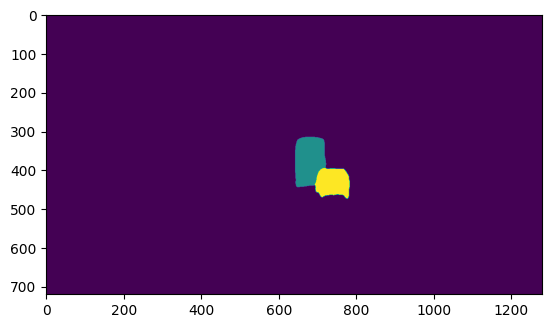

In [20]:
plt.imshow(pred_list[2])

# Time to kết hợp

### SAM

In [9]:
# sam_checkpoint = "sam/pretrained/sam_vit_l_0b3195.pth"
# model_type = "vit_l"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# # Predictor
# predictor = SamPredictor(sam)

### Seg + DeAOT

In [10]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {'points_per_side': 30,
                              'pred_iou_thresh': 0.8,
                              'stability_score_thresh': 0.9,
                              'crop_n_layers': 1,
                              'crop_n_points_downscale_factor': 2,
                              'min_mask_region_area': 200}

In [11]:
for seq in dataset:
    idx = 2639
    for frame_num, frame_path in enumerate(seq.frames[idx:], start=idx):
        print(frame_num, frame_path)
        break

2639 /home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00002640.jpg


In [ ]:
for seq in dataset:
    # Khởi tạo path để lưu output
    # output_mask_dir = f'output/test/tracking_sam/{seq.name}'
    
    # Khởi tạo từng tracker cho từng obj
    trackers = [Tracker(tracker_name, tracker_param, dataset_name, seq, obj_id)
                    for obj_id in range(1, len(seq.init_bbox()) + 1)]
    
    io_args = {
        'input_img': f'data/vot2023/{seq.name}/color',
        'output_mask_dir': f'output/test/pro_sam_aot/{seq.name}/mask',  # save pred masks
        'output_video': f'output/test/pro_sam_aot/{seq.name}/{seq.name}.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    }
    
    
    # For every sam_gap frames, we use SAM to find new objects and add them for tracking
    # larger sam_gap is faster but may not spot new objects in time
    segtracker_args = {'sam_gap': 8, # the interval to run sam to segment new objects
                       'min_area': 500, # minimal mask area to add a new mask as a new object
                       'max_obj_num': len(seq.init_bbox()), # maximal object number to track in a video
                       'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
                      }
    
    # Create output save dir
    output_dir = io_args['output_mask_dir']
    if not os.path.exists(output_dir):
        print("[INFO] Creating directory for output mask")
        os.makedirs(output_dir)
        print("[INFO] Done!")
        
    segtracker = SegTracker(io_args, segtracker_args,sam_args,aot_args)
    segtracker.restart_tracker()
    
    # SAM for ProContEXT
    predictor = SamPredictor(segtracker.sam.sam)
    
    with torch.cuda.amp.autocast(): a
        for frame_num, frame_path in enumerate(seq.frames):
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Frame đầu tiên
            if frame_num == 0:
                deaot_pred_mask = segtracker.seg(frame)
                # frame_track[frame_num] = deaot_pred_mask # Phuc them
                torch.cuda.empty_cache()
                gc.collect()
                segtracker.add_reference(frame, deaot_pred_mask)
            
            else:
                ###########################################################################
                # ProContEXT
                ###########################################################################
                boxes = []
                for tracker in trackers:
                    state = np.array(tracker.track(frame_num, frame)) # x, y, w, h
                    state[2:] += state[:2] # x, y, w, h -> t, l, b, r
                    boxes.append(state)
                print(f"{frame_num}: {boxes}")

                # Running SAM
                predictor.set_image(frame)
                input_boxes_tensor = torch.tensor(np.array(boxes), device=predictor.device)

                transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])

                # Predict mask with SAM
                masks, _, _ = predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transform_boxes,
                    multimask_output=False,
                )

                pro_out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]

                for obj_id, mask in enumerate(masks):
                    mask = (mask[0] * (obj_id + 1)).numpy()
                    pro_out_mask = np.where(mask, mask, pro_out_mask)

                # Đếm số lượng obj trong out_mask procontext
                pro_obj_cnt = len(boxes)
                ###########################################################################
                
                
                ###########################################################################
                # SAM + DeAOT
                ###########################################################################
                # Sau mỗi sam_gap frame
                if (frame_num % segtracker_args['sam_gap']) == 0:
                    seg_mask = segtracker.seg(frame)
                    
                    torch.cuda.empty_cache()
                    gc.collect()
                    
                    track_mask = segtracker.track(frame)
                    
                    # find new objects, and update tracker with new objects
                    new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)

                    save_prediction(new_obj_mask,output_dir,str(frame_num)+'_new.png')
                    deoaot_pred_mask = track_mask + new_obj_mask
                    # frame_track[frame_idx] = deoaot_pred_mask # Test Phuc
#                     segtracker.add_reference(frame, deoaot_pred_mask)

                # Các frame khác
                else:
#                     deoaot_pred_mask = segtracker.track(frame, update_memory=True)
                    # frame_track[frame_idx] = deoaot_pred_mask
                    deoaot_pred_mask = segtracker.track(frame)
                
                # Đếm số lượng obj trong pred_mask SAM_DeAOT
                deaot_obj_cnt = np.unique(deoaot_pred_mask)
                deaot_obj_cnt = len(deaot_obj_cnt[deaot_obj_cnt != 0])
                ###########################################################################
                
                # Nếu 2 mask có số lượng bằng nhau
                if pro_obj_cnt == deaot_obj_cnt:
                    print("Take mask of DeAOT: ", frame.shape, deoaot_pred_mask.shape)
                    segtracker.add_reference(frame, deoaot_pred_mask)
                    save_prediction(deoaot_pred_mask,output_dir,str(frame_num)+'.png')
                
                # Chọn procontext khi 2 mask khác nhau (tin ProConText hơn)
                else:
                    print("Take mask of ProContEXT: ", frame.shape, deoaot_pred_mask.shape)
                    segtracker.add_reference(frame, pro_out_mask)
                    save_prediction(pro_out_mask,output_dir,str(frame_num)+'.png')
                                    
                torch.cuda.empty_cache()
                gc.collect()

In [ ]:
for seq in dataset:
    # Khởi tạo path để lưu output
    # output_mask_dir = f'output/test/tracking_sam/{seq.name}'
    
    # Khởi tạo từng tracker cho từng obj
    trackers = [Tracker(tracker_name, tracker_param, dataset_name, seq, obj_id)
                    for obj_id in range(1, len(seq.init_bbox()) + 1)]
    
    io_args = {
        'input_img': f'data/vot2023/{seq.name}/color',
        'output_mask_dir': f'output/test/pro_sam_aot/{seq.name}/mask',  # save pred masks
        'output_video': f'output/test/pro_sam_aot/{seq.name}/{seq.name}.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    }
    
    
    # For every sam_gap frames, we use SAM to find new objects and add them for tracking
    # larger sam_gap is faster but may not spot new objects in time
    segtracker_args = {'sam_gap': 8, # the interval to run sam to segment new objects
                       'min_area': 500, # minimal mask area to add a new mask as a new object
                       'max_obj_num': len(seq.init_bbox()), # maximal object number to track in a video
                       'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
                      }
    
    # Create output save dir
    output_dir = io_args['output_mask_dir']
    if not os.path.exists(output_dir):
        print("[INFO] Creating directory for output mask")
        os.makedirs(output_dir)
        print("[INFO] Done!")
        
    segtracker = SegTracker(io_args, segtracker_args,sam_args,aot_args)
    segtracker.restart_tracker()
    
    # SAM for ProContEXT
    predictor = SamPredictor(segtracker.sam.sam)
    
    with torch.cuda.amp.autocast():
        for frame_num, frame_path in enumerate(seq.frames):
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Frame đầu tiên
            if frame_num == 0:
                deaot_pred_mask = segtracker.seg(frame)
                # frame_track[frame_num] = deaot_pred_mask # Phuc them
                torch.cuda.empty_cache()
                gc.collect()
                segtracker.add_reference(frame, deaot_pred_mask)
            
            else:
                ###########################################################################
                # ProContEXT
                ###########################################################################
                boxes = []
                for tracker in trackers:
                    state = np.array(tracker.track(frame_num, frame)) # x, y, w, h
                    state[2:] += state[:2] # x, y, w, h -> t, l, b, r
                    boxes.append(state)
                print(f"{frame_num}: {boxes}")

                # Running SAM
                predictor.set_image(frame)
                input_boxes_tensor = torch.tensor(np.array(boxes), device=predictor.device)

                transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])

                # Predict mask with SAM
                masks, _, _ = predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transform_boxes,
                    multimask_output=False,
                )

                pro_out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]

                for obj_id, mask in enumerate(masks):
                    mask = (mask[0] * (obj_id + 1)).numpy()
                    pro_out_mask = np.where(mask, mask, pro_out_mask)

                # Đếm số lượng obj trong out_mask procontext
                pro_obj_cnt = len(boxes)
                ###########################################################################
                
                
                ###########################################################################
                # SAM + DeAOT
                ###########################################################################
                # Sau mỗi sam_gap frame
                if (frame_num % segtracker_args['sam_gap']) == 0:
                    seg_mask = segtracker.seg(frame)
                    
                    torch.cuda.empty_cache()
                    gc.collect()
                    
                    track_mask = segtracker.track(frame)
                    
                    # find new objects, and update tracker with new objects
                    new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)

                    save_prediction(new_obj_mask,output_dir,str(frame_num)+'_new.png')
                    deoaot_pred_mask = track_mask + new_obj_mask
                    # frame_track[frame_idx] = deoaot_pred_mask # Test Phuc
#                     segtracker.add_reference(frame, deoaot_pred_mask)

                # Các frame khác
                else:
#                     deoaot_pred_mask = segtracker.track(frame, update_memory=True)
                    # frame_track[frame_idx] = deoaot_pred_mask
                    deoaot_pred_mask = segtracker.track(frame)
                
                # Đếm số lượng obj trong pred_mask SAM_DeAOT
                deaot_obj_cnt = np.unique(deoaot_pred_mask)
                deaot_obj_cnt = len(deaot_obj_cnt[deaot_obj_cnt != 0])
                ###########################################################################
                
                # Nếu 2 mask có số lượng bằng nhau
                if pro_obj_cnt == deaot_obj_cnt:
                    print("Take mask of DeAOT: ", frame.shape, deoaot_pred_mask.shape)
                    segtracker.add_reference(frame, deoaot_pred_mask)
                    save_prediction(deoaot_pred_mask,output_dir,str(frame_num)+'.png')
                
                # Chọn procontext khi 2 mask khác nhau (tin ProConText hơn)
                else:
                    print("Take mask of ProContEXT: ", frame.shape, deoaot_pred_mask.shape)
                    segtracker.add_reference(frame, pro_out_mask)
                    save_prediction(pro_out_mask,output_dir,str(frame_num)+'.png')
                                    
                torch.cuda.empty_cache()
                gc.collect()

Init info:  {'init_bbox': [642.0, 315.0, 78.0, 128.0]}
[642.0, 315.0, 78.0, 128.0]
Init info:  {'init_bbox': [694.0, 396.0, 89.0, 76.0]}
[694.0, 396.0, 89.0, 76.0]


/home/son/miniconda3/envs/ostrack/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized
1: [array([640, 313, 718, 442]), array([693, 396, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2: [array([640, 313, 718, 442]), array([693, 395, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
3: [array([640, 313, 719, 442]), array([693, 396, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
4: [array([640, 314, 719, 442]), array([693, 396, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
5: [array([640, 314, 719, 444]), array([693, 395, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
6: [array([640, 312, 719, 441]), array([693, 395, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
7: [array([640, 314, 719, 442]), array([692, 395, 782, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
8: [array([640, 313, 719, 443]), array([693, 396, 783, 471])]
Take 

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
74: [array([637, 313, 719, 443]), array([693, 394, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
75: [array([637, 313, 719, 442]), array([693, 395, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
76: [array([637, 313, 719, 442]), array([692, 395, 782, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
77: [array([637, 312, 719, 442]), array([692, 394, 782, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
78: [array([637, 313, 719, 443]), array([692, 394, 782, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
79: [array([637, 314, 719, 443]), array([693, 394, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
80: [array([637, 312, 719, 443]), array([693, 395, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
81: [array([637, 313, 719, 443]), array([693, 395, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
82: [array([636, 313, 718, 442]), array([692, 395, 782, 471])]
T

147: [array([637, 313, 719, 442]), array([693, 393, 783, 470])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
148: [array([637, 313, 720, 443]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
149: [array([637, 314, 719, 444]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
150: [array([637, 313, 720, 442]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
151: [array([637, 313, 719, 442]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
152: [array([637, 313, 719, 443]), array([693, 393, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
153: [array([637, 313, 718, 442]), array([693, 393, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
154: [array([637, 313, 719, 443]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
155: [array([637, 313, 719, 442]), array([693, 394, 783, 471])]
Take mask of DeAOT:  (720, 1280, 3) (720

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
221: [array([645, 318, 715, 431]), array([684, 389, 763, 459])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
222: [array([645, 318, 715, 430]), array([684, 389, 762, 459])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
223: [array([645, 318, 715, 430]), array([683, 389, 761, 458])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
224: [array([646, 318, 716, 430]), array([684, 389, 762, 458])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
225: [array([647, 319, 716, 431]), array([683, 389, 760, 457])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
226: [array([647, 319, 716, 430]), array([683, 388, 760, 457])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
227: [array([647, 319, 716, 430]), array([683, 388, 759, 456])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
228: [array([647, 319, 716, 430]), array([683, 388, 759, 456])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
229: [array([648, 319, 716, 429]), array([683, 387, 758,

294: [array([668, 325, 726, 413]), array([684, 381, 735, 430])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
295: [array([668, 325, 725, 414]), array([684, 381, 735, 430])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
296: [array([668, 325, 725, 414]), array([684, 381, 735, 430])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
297: [array([669, 325, 725, 414]), array([683, 381, 734, 429])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
298: [array([670, 324, 726, 412]), array([684, 381, 734, 429])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
299: [array([670, 325, 726, 412]), array([685, 380, 735, 429])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
300: [array([671, 325, 726, 412]), array([684, 380, 734, 428])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
301: [array([671, 325, 726, 412]), array([684, 380, 734, 428])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
302: [array([671, 326, 725, 412]), array([684, 380, 734, 428])]
Take mask of DeAOT:  (720, 1280, 3) (720

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
368: [array([683, 330, 728, 401]), array([694, 373, 735, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
369: [array([684, 329, 729, 401]), array([694, 373, 735, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
370: [array([683, 329, 728, 401]), array([695, 373, 735, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
371: [array([683, 329, 728, 400]), array([695, 374, 735, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
372: [array([684, 329, 729, 400]), array([695, 374, 735, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
373: [array([683, 329, 728, 399]), array([695, 374, 735, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
374: [array([684, 329, 729, 399]), array([696, 373, 736, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
375: [array([684, 330, 728, 399]), array([696, 373, 736, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
376: [array([684, 330, 728, 399]), array([696, 373, 735,

441: [array([690, 331, 730, 395]), array([701, 370, 736, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
442: [array([691, 331, 731, 395]), array([702, 369, 737, 402])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
443: [array([691, 331, 731, 395]), array([701, 370, 736, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
444: [array([691, 330, 730, 394]), array([702, 370, 737, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
445: [array([692, 330, 732, 394]), array([702, 370, 737, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
446: [array([691, 331, 730, 395]), array([703, 370, 738, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
447: [array([691, 330, 730, 394]), array([702, 370, 737, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
448: [array([692, 331, 731, 395]), array([702, 369, 737, 402])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
449: [array([693, 331, 732, 395]), array([702, 370, 737, 403])]
Take mask of DeAOT:  (720, 1280, 3) (720

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
515: [array([692, 336, 732, 398]), array([702, 374, 736, 405])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
516: [array([692, 335, 732, 397]), array([702, 374, 737, 404])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
517: [array([693, 336, 732, 398]), array([703, 374, 737, 404])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
518: [array([693, 335, 732, 397]), array([703, 374, 737, 405])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
519: [array([693, 335, 732, 397]), array([702, 374, 737, 405])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
520: [array([693, 336, 733, 398]), array([703, 374, 737, 404])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
521: [array([693, 336, 733, 398]), array([703, 374, 737, 405])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
522: [array([692, 336, 732, 398]), array([704, 375, 738, 406])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
523: [array([693, 336, 733, 398]), array([703, 374, 737,

588: [array([685, 334, 728, 404]), array([694, 378, 734, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
589: [array([685, 334, 729, 404]), array([694, 378, 734, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
590: [array([686, 334, 730, 404]), array([694, 378, 734, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
591: [array([686, 334, 729, 404]), array([695, 378, 734, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
592: [array([686, 334, 729, 404]), array([695, 378, 735, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
593: [array([686, 334, 729, 405]), array([695, 378, 735, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
594: [array([686, 334, 729, 405]), array([696, 378, 736, 411])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
595: [array([687, 334, 730, 405]), array([696, 379, 736, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
596: [array([687, 334, 730, 404]), array([696, 378, 736, 412])]
Take mask of DeAOT:  (720, 1280, 3) (720

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
662: [array([758, 322, 815, 409]), array([774, 378, 822, 423])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
663: [array([760, 323, 816, 411]), array([776, 379, 824, 424])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
664: [array([761, 323, 818, 410]), array([778, 380, 827, 425])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
665: [array([763, 323, 820, 412]), array([780, 380, 828, 425])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
666: [array([765, 324, 823, 412]), array([782, 381, 830, 426])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
667: [array([767, 324, 825, 413]), array([784, 382, 833, 427])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
668: [array([769, 325, 827, 414]), array([786, 382, 835, 426])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
669: [array([771, 325, 830, 414]), array([788, 382, 839, 428])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
670: [array([773, 325, 832, 415]), array([791, 383, 841,

735: [array([835, 314, 912, 438]), array([863, 395, 935, 462])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
736: [array([834, 313, 911, 438]), array([862, 395, 935, 462])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
737: [array([834, 313, 912, 439]), array([862, 395, 935, 462])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
738: [array([834, 313, 912, 439]), array([862, 395, 935, 462])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
739: [array([833, 312, 911, 439]), array([860, 396, 934, 464])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
740: [array([832, 313, 910, 440]), array([860, 395, 934, 464])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
741: [array([832, 311, 910, 440]), array([860, 395, 934, 464])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
742: [array([831, 313, 910, 441]), array([859, 395, 934, 464])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
743: [array([830, 311, 909, 441]), array([859, 395, 934, 465])]
Take mask of DeAOT:  (720, 1280, 3) (720

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
809: [array([779, 295, 901, 477]), array([827, 423, 951, 541])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
810: [array([779, 295, 901, 478]), array([826, 424, 951, 543])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
811: [array([778, 294, 900, 480]), array([826, 424, 953, 544])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
812: [array([778, 293, 900, 480]), array([826, 425, 954, 546])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
813: [array([777, 293, 900, 480]), array([825, 426, 954, 548])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
814: [array([776, 294, 899, 482]), array([824, 427, 954, 550])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
815: [array([776, 294, 900, 484]), array([824, 428, 956, 551])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
816: [array([774, 293, 899, 484]), array([824, 429, 956, 553])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
817: [array([774, 292, 899, 485]), array([823, 430, 957,

881: [array([748, 266, 922, 551]), array([ 828,  463, 1094,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
882: [array([748, 265, 923, 551]), array([ 828,  464, 1098,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
883: [array([748, 265, 924, 552]), array([ 828,  465, 1102,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
884: [array([748, 264, 925, 554]), array([ 829,  466, 1106,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
885: [array([746, 264, 925, 554]), array([ 828,  467, 1108,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
886: [array([747, 264, 927, 556]), array([ 829,  469, 1113,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
887: [array([748, 263, 929, 558]), array([ 826,  470, 1116,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
888: [array([747, 263, 929, 559]), array([ 828,  472, 1121,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
889: [array([747, 262, 930, 560]), array([ 827,  473, 1124,  717])]
Take

951: [array([746, 245, 965, 596]), array([ 848,  489, 1269,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
952: [array([747, 245, 964, 597]), array([ 847,  491, 1270,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
953: [array([748, 246, 965, 598]), array([ 847,  491, 1271,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
954: [array([747, 246, 964, 597]), array([ 848,  491, 1274,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
955: [array([747, 247, 965, 598]), array([ 850,  491, 1272,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
956: [array([748, 247, 965, 599]), array([ 847,  494, 1273,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
957: [array([747, 247, 965, 598]), array([ 851,  491, 1271,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
958: [array([747, 247, 965, 598]), array([ 846,  493, 1272,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
959: [array([747, 247, 964, 598]), array([ 849,  492

1020: [array([748, 249, 963, 596]), array([ 846,  442, 1273,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1021: [array([747, 249, 962, 596]), array([ 845,  432, 1275,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1022: [array([747, 249, 962, 596]), array([ 847,  433, 1271,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1023: [array([748, 249, 963, 596]), array([ 845,  434, 1273,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1024: [array([747, 250, 963, 595]), array([ 848,  435, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1025: [array([749, 249, 963, 597]), array([ 846,  432, 1272,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1026: [array([747, 249, 963, 594]), array([ 848,  434, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1027: [array([748, 249, 964, 598]), array([ 847,  433, 1271,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1028: [array([748, 249, 964, 597]), array([ 

1089: [array([748, 250, 963, 600]), array([ 838,  380, 1272,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1090: [array([747, 250, 964, 598]), array([ 839,  379, 1272,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1091: [array([746, 250, 963, 598]), array([ 835,  375, 1272,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1092: [array([747, 249, 963, 598]), array([ 836,  373, 1272,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1093: [array([747, 250, 963, 599]), array([ 836,  372, 1272,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1094: [array([747, 249, 963, 598]), array([ 835,  372, 1270,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1095: [array([747, 250, 963, 599]), array([ 836,  371, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1096: [array([747, 250, 964, 598]), array([ 834,  372, 1271,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1097: [array([746, 250, 963, 598]), array([ 

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1158: [array([747, 249, 964, 601]), array([ 821,  374, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1159: [array([747, 249, 964, 600]), array([ 814,  374, 1271,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1160: [array([747, 248, 964, 600]), array([ 831,  374, 1268,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1161: [array([748, 249, 964, 599]), array([ 834,  372, 1266,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1162: [array([747, 249, 963, 599]), array([ 835,  373, 1268,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1163: [array([747, 249, 962, 599]), array([ 834,  371, 1267,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1164: [array([748, 249, 964, 599]), array([ 834,  374, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1165: [array([748, 249, 964, 598]), array([ 833,  372, 1266,  717])]
Take mask of DeAOT:  (720, 1280, 3

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1226: [array([748, 248, 963, 595]), array([ 828,  360, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1227: [array([748, 248, 963, 595]), array([ 830,  359, 1273,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1228: [array([748, 247, 963, 595]), array([ 828,  356, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1229: [array([747, 248, 963, 595]), array([ 825,  361, 1271,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1230: [array([748, 248, 963, 595]), array([ 828,  360, 1272,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1231: [array([747, 248, 962, 595]), array([ 833,  353, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1232: [array([748, 247, 962, 595]), array([ 830,  356, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1233: [array([747, 247, 962, 593]), array([ 830,  357, 1269,  714])]
Take mask of ProContEXT:

1293: [array([748, 247, 963, 597]), array([ 835,  359, 1273,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1294: [array([748, 247, 963, 596]), array([ 835,  358, 1276,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1295: [array([747, 248, 963, 596]), array([ 835,  356, 1273,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1296: [array([748, 247, 963, 597]), array([ 833,  358, 1273,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1297: [array([747, 247, 963, 595]), array([ 834,  357, 1276,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1298: [array([748, 247, 963, 597]), array([ 835,  358, 1272,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1299: [array([747, 247, 963, 595]), array([ 834,  357, 1274,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1300: [array([747, 248, 963, 597]), array([ 834,  356, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1301: [array([748, 247, 

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1361: [array([742, 248, 961, 597]), array([ 836,  355, 1272,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1362: [array([743, 249, 961, 598]), array([ 833,  351, 1269,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1363: [array([743, 247, 962, 597]), array([ 835,  355, 1270,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1364: [array([743, 248, 961, 597]), array([ 833,  352, 1272,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1365: [array([743, 247, 961, 597]), array([ 833,  351, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1366: [array([743, 248, 961, 597]), array([ 834,  356, 1272,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1367: [array([744, 249, 961, 598]), array([ 834,  351, 1269,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1368: [array([743, 247, 961, 598]), array([ 837,  355, 1272,  716])]
Take mask of DeAOT:  (720, 1280, 3

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1429: [array([746, 247, 962, 596]), array([ 830,  350, 1273,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1430: [array([745, 247, 961, 598]), array([ 831,  346, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1431: [array([744, 246, 960, 597]), array([ 826,  347, 1269,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1432: [array([744, 247, 960, 596]), array([ 830,  350, 1272,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1433: [array([745, 247, 962, 596]), array([ 826,  349, 1269,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1434: [array([744, 248, 960, 599]), array([ 830,  348, 1273,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1435: [array([745, 247, 961, 596]), array([ 826,  345, 1270,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1436: [array([745, 247, 961, 596]), array([ 827,  348, 1268,  713])]
Take mask of ProContEXT:  (720, 1280, 3

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1497: [array([746, 247, 961, 596]), array([ 833,  339, 1267,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1498: [array([745, 247, 960, 595]), array([ 831,  334, 1266,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1499: [array([745, 247, 961, 594]), array([ 833,  340, 1266,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1500: [array([745, 247, 961, 596]), array([ 834,  337, 1270,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1501: [array([745, 246, 961, 596]), array([ 832,  329, 1270,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1502: [array([744, 247, 960, 596]), array([ 836,  330, 1271,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1503: [array([745, 247, 962, 596]), array([ 834,  327, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1504: [array([745, 247, 961, 596]), array([ 837,  328, 1269,  716])]
Take mask of DeAOT:  (72

1565: [array([745, 247, 962, 594]), array([ 830,  306, 1269,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1566: [array([745, 246, 960, 595]), array([ 834,  307, 1269,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1567: [array([745, 247, 961, 594]), array([ 834,  306, 1269,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1568: [array([745, 247, 960, 595]), array([ 835,  309, 1270,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1569: [array([746, 247, 962, 595]), array([ 832,  306, 1270,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1570: [array([746, 247, 962, 596]), array([ 832,  308, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1571: [array([746, 246, 961, 594]), array([ 832,  304, 1269,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1572: [array([747, 247, 961, 595]), array([ 832,  304, 1269,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1573: [array([746, 247, 961, 

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1634: [array([744, 247, 960, 594]), array([ 833,  309, 1270,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1635: [array([744, 247, 960, 594]), array([ 833,  309, 1269,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1636: [array([744, 247, 960, 594]), array([ 834,  307, 1270,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1637: [array([745, 247, 961, 594]), array([ 831,  308, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1638: [array([745, 247, 961, 594]), array([ 830,  306, 1269,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1639: [array([745, 247, 960, 595]), array([ 831,  305, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1640: [array([744, 246, 960, 593]), array([ 832,  308, 1269,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1641: [array([744, 247, 961, 594]), array([ 832,  302, 1269,  718])]
Take mask of ProContEXT:  (720, 12

1702: [array([747, 247, 961, 598]), array([ 831,  306, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1703: [array([747, 247, 961, 598]), array([ 829,  306, 1266,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1704: [array([746, 248, 961, 598]), array([ 830,  305, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1705: [array([747, 247, 961, 598]), array([ 829,  306, 1266,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1706: [array([747, 247, 961, 597]), array([ 831,  306, 1267,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1707: [array([747, 247, 961, 597]), array([ 830,  305, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1708: [array([747, 247, 961, 597]), array([ 832,  304, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1709: [array([747, 247, 961, 597]), array([ 830,  307, 1267,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1710: [array([747, 247, 961, 597]), array([ 832, 

1771: [array([747, 247, 960, 595]), array([ 830,  308, 1268,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1772: [array([749, 247, 961, 595]), array([ 831,  305, 1268,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1773: [array([747, 247, 961, 595]), array([ 830,  304, 1267,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1774: [array([748, 247, 960, 595]), array([ 833,  304, 1269,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1775: [array([749, 246, 962, 594]), array([ 831,  305, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1776: [array([747, 247, 961, 595]), array([ 830,  307, 1266,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1777: [array([748, 247, 960, 595]), array([ 830,  306, 1266,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1778: [array([749, 246, 961, 594]), array([ 828,  307, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1779: [array([748, 246, 961, 594]), array([ 

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1840: [array([749, 248, 960, 594]), array([ 830,  305, 1269,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1841: [array([748, 248, 960, 595]), array([ 830,  304, 1268,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1842: [array([748, 248, 960, 594]), array([ 829,  305, 1267,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1843: [array([747, 248, 960, 594]), array([ 829,  305, 1267,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1844: [array([748, 248, 961, 594]), array([ 829,  305, 1270,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1845: [array([747, 248, 959, 593]), array([ 829,  309, 1269,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1846: [array([747, 248, 960, 594]), array([ 830,  307, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1847: [array([748, 248, 960, 594]), array([ 830,  309, 1269,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 12

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1909: [array([747, 248, 961, 596]), array([ 831,  302, 1267,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1910: [array([746, 248, 959, 597]), array([ 831,  302, 1267,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1911: [array([746, 247, 960, 595]), array([ 832,  301, 1267,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1912: [array([746, 247, 960, 595]), array([ 832,  303, 1267,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1913: [array([746, 249, 960, 596]), array([ 833,  304, 1268,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
1914: [array([746, 248, 960, 595]), array([ 833,  304, 1268,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1915: [array([746, 247, 959, 595]), array([ 833,  303, 1268,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1916: [array([746, 248, 960, 595]), array([ 833,  305, 1267,  713])]
Take mask of DeAOT:  (720, 1280, 3) (72

1977: [array([747, 249, 961, 598]), array([ 833,  303, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1978: [array([746, 249, 959, 599]), array([ 832,  304, 1269,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1979: [array([747, 249, 960, 599]), array([ 832,  304, 1268,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1980: [array([747, 248, 961, 598]), array([ 833,  302, 1269,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1981: [array([745, 249, 960, 599]), array([ 832,  303, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1982: [array([745, 249, 960, 598]), array([ 833,  304, 1270,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1983: [array([746, 249, 960, 599]), array([ 831,  304, 1269,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1984: [array([746, 249, 960, 598]), array([ 832,  303, 1269,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
1985: [array([746, 249, 

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2046: [array([747, 248, 960, 597]), array([ 826,  306, 1266,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2047: [array([748, 248, 961, 598]), array([ 834,  302, 1264,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2048: [array([747, 248, 960, 597]), array([ 830,  304, 1266,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2049: [array([748, 248, 961, 597]), array([ 829,  302, 1268,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2050: [array([748, 248, 960, 597]), array([ 831,  305, 1270,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2051: [array([748, 248, 961, 597]), array([ 828,  304, 1273,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2052: [array([748, 248, 961, 598]), array([ 827,  306, 1276,  712])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2053: [array([747, 248, 960, 597]), array([ 829,  305, 1275,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (72

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2115: [array([749, 248, 960, 595]), array([ 830,  299, 1266,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2116: [array([749, 248, 960, 596]), array([ 830,  300, 1266,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2117: [array([749, 248, 961, 596]), array([ 828,  301, 1266,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2118: [array([749, 248, 960, 595]), array([ 834,  300, 1266,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2119: [array([749, 248, 961, 596]), array([ 828,  300, 1264,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2120: [array([748, 248, 960, 594]), array([ 831,  300, 1266,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2121: [array([747, 247, 959, 595]), array([ 832,  298, 1267,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2122: [array([747, 248, 959, 596]), array([ 832,  298, 1267,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (72

2183: [array([745, 248, 958, 596]), array([ 832,  307, 1268,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2184: [array([745, 248, 959, 596]), array([ 831,  310, 1267,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2185: [array([745, 248, 959, 597]), array([ 833,  308, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2186: [array([746, 248, 960, 596]), array([ 831,  309, 1266,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2187: [array([746, 248, 960, 597]), array([ 833,  308, 1267,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2188: [array([745, 248, 959, 597]), array([ 831,  308, 1267,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2189: [array([745, 248, 959, 597]), array([ 830,  305, 1268,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2190: [array([746, 249, 960, 597]), array([ 829,  308, 1267,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2191: [array([746, 248, 960, 598])

2251: [array([747, 249, 961, 599]), array([ 826,  305, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2252: [array([747, 248, 960, 600]), array([ 833,  306, 1266,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2253: [array([747, 249, 960, 600]), array([ 826,  305, 1269,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2254: [array([747, 248, 960, 599]), array([ 832,  305, 1265,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2255: [array([747, 248, 960, 600]), array([ 828,  304, 1268,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2256: [array([747, 248, 960, 600]), array([ 827,  304, 1267,  718])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2257: [array([747, 249, 961, 600]), array([ 833,  308, 1266,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2258: [array([747, 249, 961, 601]), array([ 828,  306, 1269,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2259: [array([747, 249, 960, 601]), arr

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2320: [array([747, 248, 961, 599]), array([ 824,  325, 1269,  713])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2321: [array([747, 248, 960, 600]), array([ 826,  325, 1270,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2322: [array([748, 247, 960, 599]), array([ 825,  324, 1269,  717])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2323: [array([748, 247, 961, 599]), array([ 824,  327, 1270,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2324: [array([747, 248, 959, 599]), array([ 825,  324, 1272,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2325: [array([748, 247, 961, 599]), array([ 824,  325, 1269,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2326: [array([748, 247, 961, 600]), array([ 827,  325, 1271,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2327: [array([747, 248, 960, 600]), array([ 827,  325, 1270,  714])]
Take mask of ProContEXT:  (720, 12

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2388: [array([745, 248, 961, 598]), array([ 830,  307, 1268,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2389: [array([745, 247, 960, 599]), array([ 831,  304, 1268,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2390: [array([745, 249, 961, 599]), array([ 831,  306, 1268,  713])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2391: [array([745, 248, 960, 599]), array([ 828,  306, 1269,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2392: [array([745, 248, 960, 599]), array([ 829,  308, 1268,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2393: [array([744, 249, 960, 599]), array([ 830,  310, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2394: [array([745, 249, 961, 599]), array([ 828,  307, 1268,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2395: [array([744, 249, 960, 600]), array([ 829,  306, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3

2456: [array([748, 248, 962, 598]), array([ 828,  312, 1268,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2457: [array([748, 249, 961, 599]), array([ 827,  308, 1269,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2458: [array([748, 248, 961, 598]), array([ 828,  312, 1268,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2459: [array([749, 248, 962, 598]), array([ 828,  308, 1268,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2460: [array([748, 248, 962, 598]), array([ 829,  314, 1268,  712])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2461: [array([748, 248, 962, 598]), array([ 829,  312, 1269,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2462: [array([748, 248, 961, 598]), array([ 826,  312, 1268,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2463: [array([748, 248, 961, 598]), array([ 826,  313, 1267,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2464: [array([749, 248, 961, 598])

Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2525: [array([747, 248, 960, 598]), array([ 827,  306, 1267,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2526: [array([747, 248, 960, 598]), array([ 830,  314, 1267,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2527: [array([746, 249, 959, 598]), array([ 829,  307, 1267,  719])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2528: [array([747, 248, 960, 598]), array([ 827,  312, 1267,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2529: [array([748, 248, 961, 598]), array([ 827,  309, 1268,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2530: [array([747, 248, 960, 598]), array([ 830,  313, 1267,  717])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2531: [array([748, 248, 961, 598]), array([ 827,  311, 1269,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2532: [array([747, 249, 960, 599]), array([ 826,  312, 1271,  715])]
Take mask of ProContEXT:  (720, 1280, 3) (72

Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2594: [array([747, 248, 959, 595]), array([ 830,  310, 1269,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2595: [array([748, 248, 961, 595]), array([ 828,  307, 1271,  718])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2596: [array([747, 248, 959, 595]), array([ 826,  311, 1271,  716])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2597: [array([748, 249, 961, 596]), array([ 826,  307, 1270,  716])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2598: [array([749, 248, 960, 595]), array([ 831,  311, 1268,  714])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2599: [array([747, 248, 959, 595]), array([ 830,  308, 1271,  719])]
Take mask of ProContEXT:  (720, 1280, 3) (720, 1280)
2600: [array([747, 249, 959, 596]), array([ 827,  310, 1271,  715])]
Take mask of DeAOT:  (720, 1280, 3) (720, 1280)
2601: [array([749, 248, 960, 595]), array([ 826,  310, 1269,  714])]
Take mask of ProContEXT:  (720, 1280, 3) (72

In [ ]:
frame.shape, deoaot_pred_mask.shape

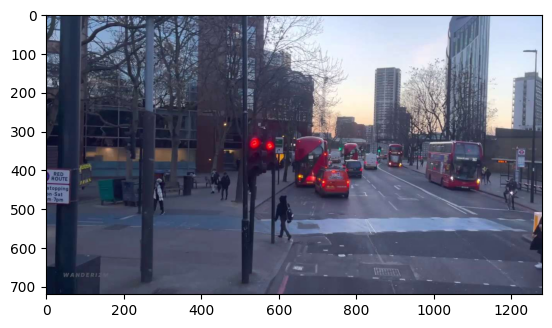

In [16]:
plt.imshow(frame)
# plt.imshow(deaot_pred_mask)

In [ ]:
frame_track = {}
pred_list = []
masked_pred_list = []

with torch.cuda.amp.autocast():
    for frame_idx in range(0, len(os.listdir(io_args['input_img']))):
        img_path = os.path.join(io_args['input_img'], "%08d.jpg" % (frame_idx + 1))
        frame = cv2.imread(img_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Initialization: Add ground-truth mask to segtracker
        if frame_idx == 0:
            pred_mask = segtracker.seg(frame)
            frame_track[frame_idx] = pred_mask
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        
        elif (frame_idx % segtracker_args['sam_gap']) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)

            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            frame_track[frame_idx] = pred_mask # Test Phuc
            segtracker.add_reference(frame, pred_mask)
        
        else:
            pred_mask = segtracker.track(frame, update_memory=True)
            frame_track[frame_idx] = pred_mask
        
        torch.cuda.empty_cache()
        gc.collect()
        
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        
        #########################################
        # Cho mask của procontext vào đây
        #########################################
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        
        if frame_idx == 3:
            break